In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(unglue))
theme_set(theme_classic(22))

In [2]:
files <- fs::dir_ls("output/bed/")
unglue_str <- "output/bed/rep-{rep}_seed1-{seed1}_seed2-{seed2}_startfreq-{start_freq}_endfreq-{end_freq}_sub-{sub}.bed"

#read in interval information for each sim
suppressMessages(
    full_df <- 
    files %>% 
    map_df(~ {
        bed_df <- read_delim(.x, "\t", col_names = c("chrom", "start", "end", "mu"))
        meta_df <- unglue(.x, unglue_str)[[1]] %>% 
            mutate_all(as.numeric)
        bind_cols(bed_df, meta_df)
    }) %>% 
    mutate(
        sweep_type = ifelse(start_freq == 0, "hard", "soft"),
        complete = ifelse(end_freq <= 0.5, "incomplete", "complete")
    )
) 
head(arrange(full_df, rep, sub))


chrom,start,end,mu,rep,seed1,seed2,start_freq,end_freq,sub,sweep_type,complete
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
ch1,86581,376973,10.470,0,197463,907354,0,0.999,1,hard,complete
ch1,179848,198520,8.597,0,197463,907354,0,0.999,2,hard,complete
ch1,373036,373427,6.376,0,197463,907354,0,0.999,2,hard,complete
ch1,99018,271851,8.022,1,9039,219404,0,0.999,1,hard,complete
ch1,386542,387403,6.597,1,9039,219404,0,0.999,1,hard,complete
ch1,41841,91579,8.547,1,9039,219404,0,0.999,2,hard,complete


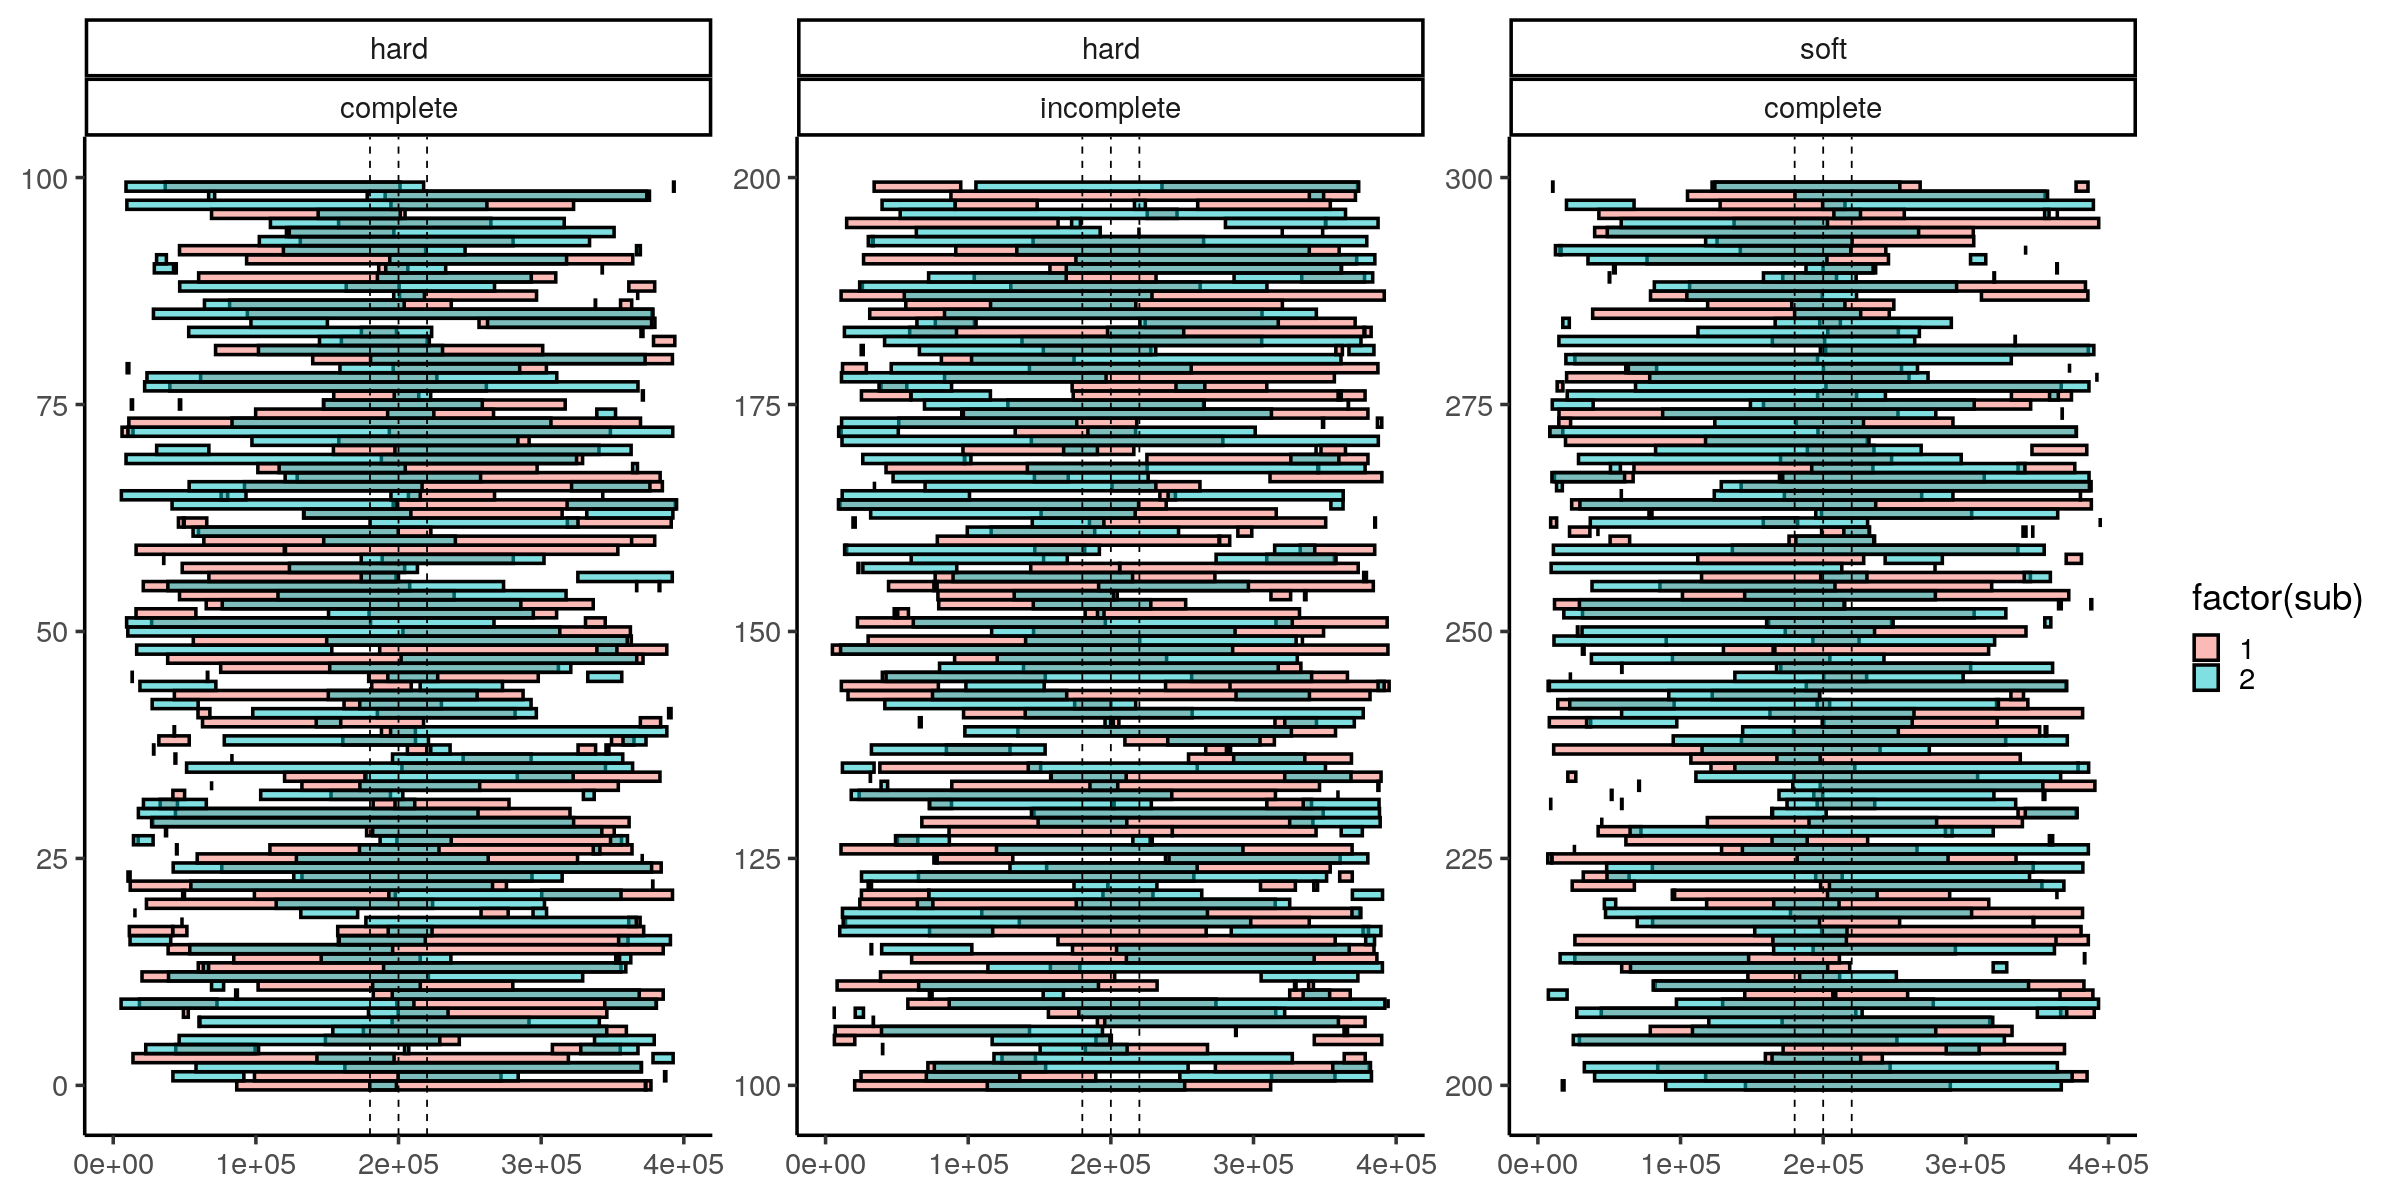

In [3]:
options(repr.plot.width=20, repr.plot.height=10)

near_x  <- 0.1
sweep_pos  <- 200000
rw <- 0.5
full_df %>% 
arrange(rep, sub) %>% 
    group_by(sweep_type, complete, rep) %>% 
    ggplot() +
    geom_rect(aes(xmin=start, ymin = rep-rw, xmax = end, ymax = rep+rw, fill = factor(sub)), colour = "black", lwd = 1, alpha = 0.5) +
    geom_vline(xintercept = sweep_pos, lty = 2) +
    geom_vline(xintercept = sweep_pos*(1+near_x), lty = 2) +
    geom_vline(xintercept = sweep_pos*(1-near_x), lty = 2) +
    facet_wrap(~sweep_type + complete, scales = "free") +
    coord_cartesian(xlim=c(0, 4e5))


In [4]:
head(full_df)

print("in how many sims did both reps overlap with true sweep region?")
full_df %>% 
    mutate(overlaps_sweep = start < sweep_pos & end >= sweep_pos) %>% 
    mutate(near_sweep = start <= sweep_pos*(1+near_x) & end >= sweep_pos*(1-near_x)) %>% 
    group_by(rep, sweep_type, complete) %>% 
    summarise(both_at = sum(overlaps_sweep), both_near = sum(near_sweep)) %>% 
    group_by(sweep_type, complete) %>% 
    summarise(p_overlap = mean(both_at == 2), p_near = mean(both_near == 2))
    
print("how large are sweep regions?")
full_df %>% 
    mutate(size = end - start) %>% 
    summarise(mean_size = mean(size), sd_size = sd(size))

print("how many are there?")
full_df %>% 
    group_by(rep) %>% 
    summarise(count = n()) %>% 
    summarise(min(count), max(count), median(count))



chrom,start,end,mu,rep,seed1,seed2,start_freq,end_freq,sub,sweep_type,complete
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
ch1,86581,376973,10.470,0,197463,907354,0,0.999,1,hard,complete
ch1,179848,198520,8.597,0,197463,907354,0,0.999,2,hard,complete
ch1,373036,373427,6.376,0,197463,907354,0,0.999,2,hard,complete
ch1,20418,312023,9.836,100,599894,458109,0,0.500,1,hard,incomplete
ch1,113372,251767,8.209,100,599894,458109,0,0.500,2,hard,incomplete
ch1,24848,189439,6.886,101,144013,472805,0,0.500,1,hard,incomplete


[1] "in how many sims did both reps overlap with true sweep region?"


`summarise()` has grouped output by 'rep', 'sweep_type'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'sweep_type'. You can override using the `.groups` argument.



sweep_type,complete,p_overlap,p_near
<chr>,<chr>,<dbl>,<dbl>
hard,complete,0.72,0.89
hard,incomplete,0.47,0.65
soft,complete,0.74,0.93


[1] "how large are sweep regions?"


mean_size,sd_size
<dbl>,<dbl>
112983.1,101311.9


[1] "how many are there?"


min(count),max(count),median(count)
<int>,<int>,<dbl>
2,6,3



── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  pos = col_double(),
  mu = col_double()
)




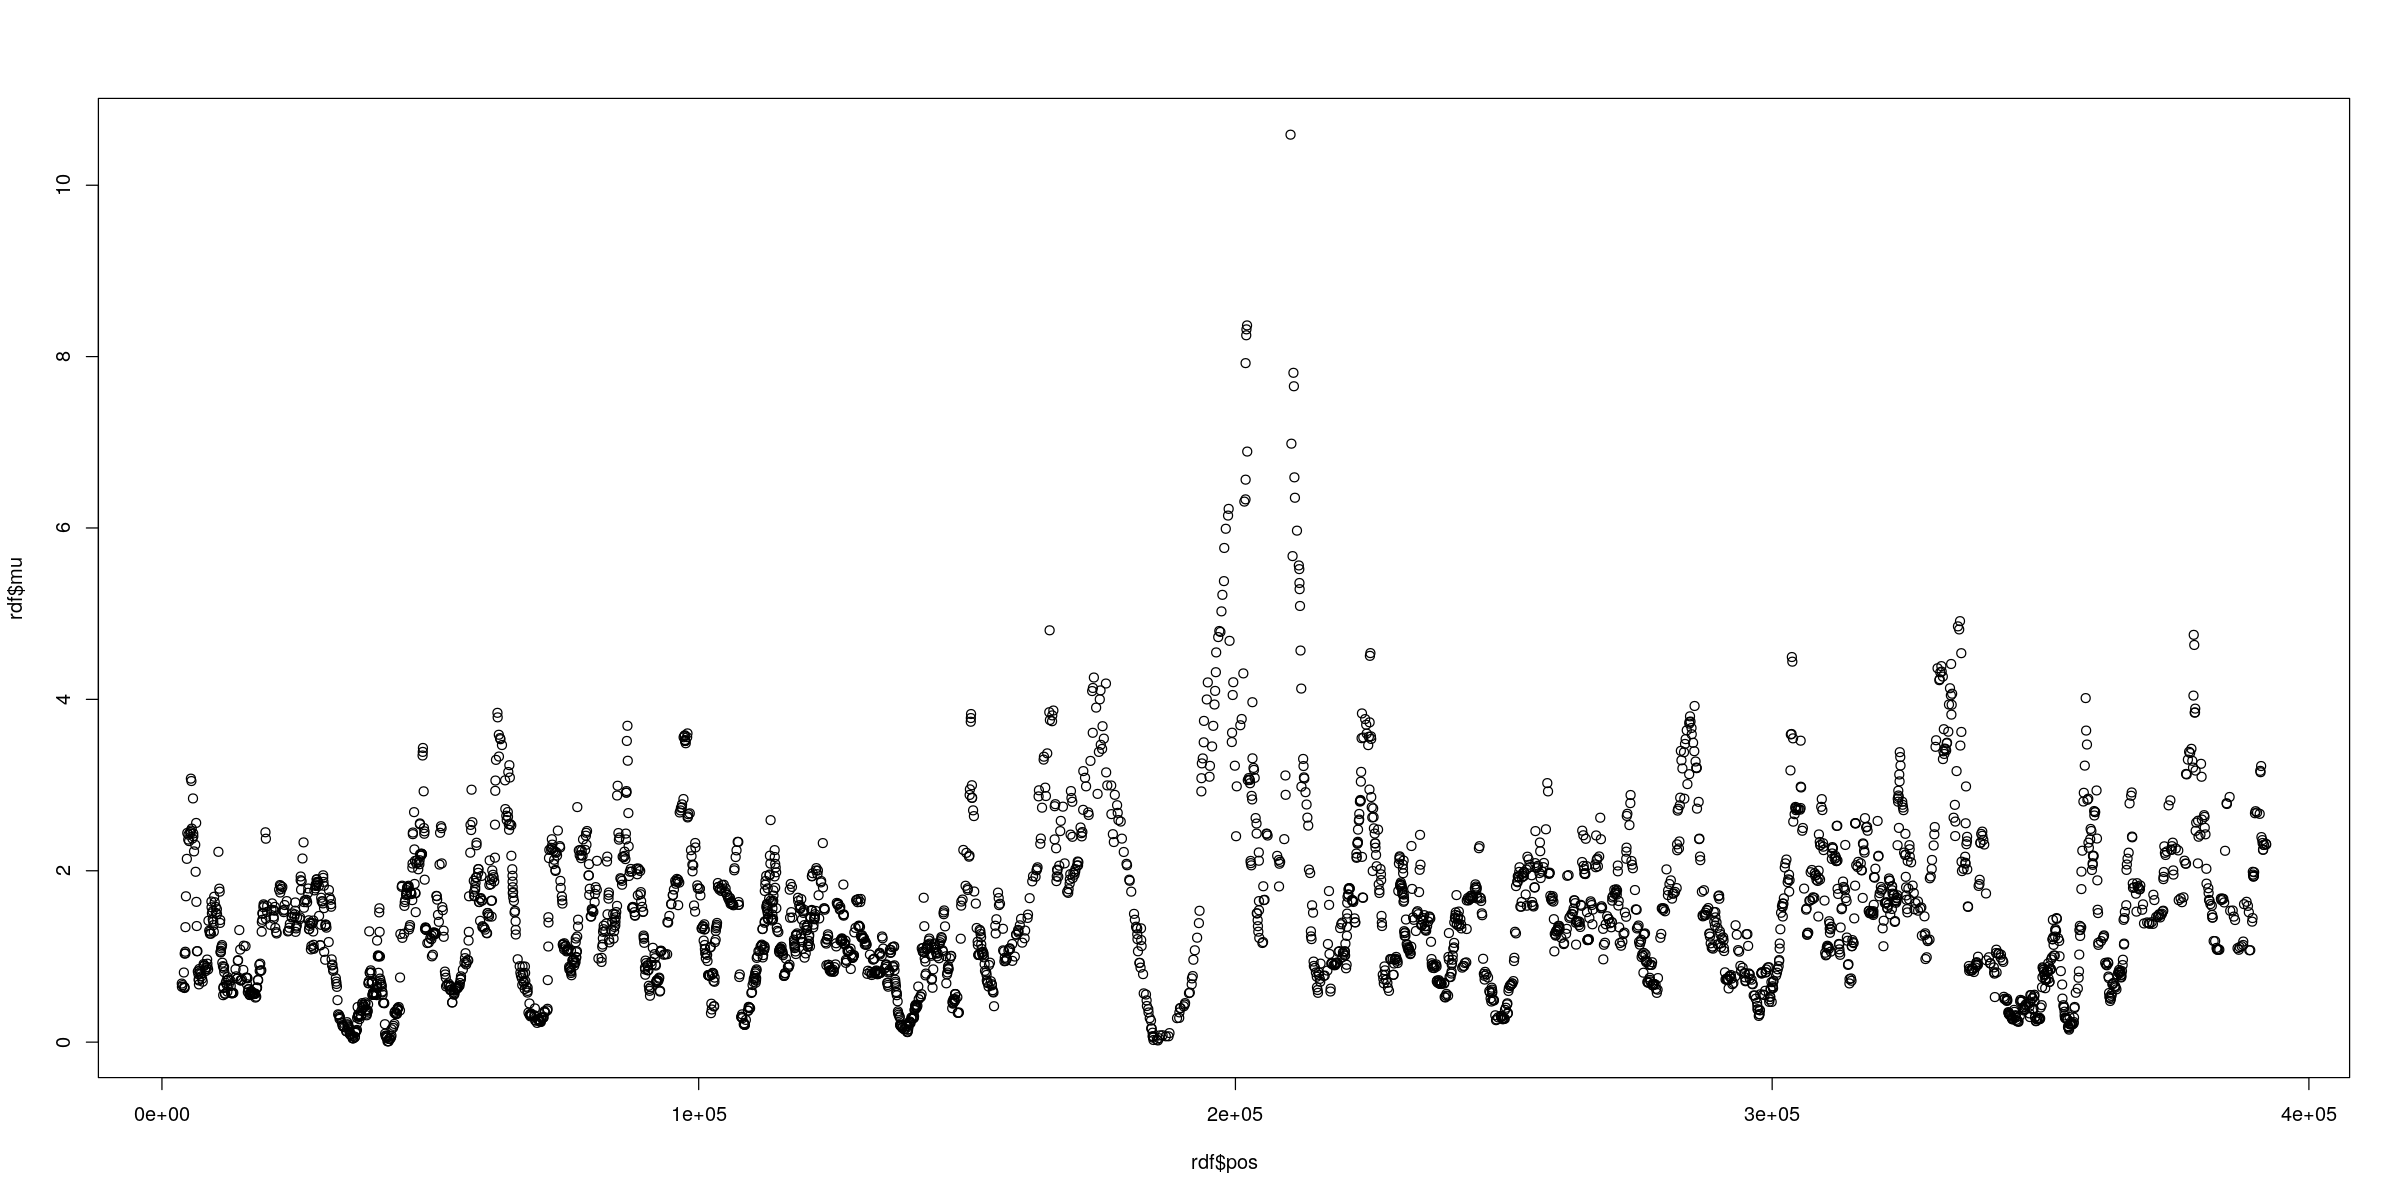

In [5]:
raisd_files <- fs::dir_ls("output/raisd/", glob = "*RAiSD_Report*")
rdf <- read_delim(sample(raisd_files, 1), "\t", skip = 1, col_names = c("pos", "mu"))
plot(rdf$pos, rdf$mu)